# Semester Project - Continuous time quantization simulation 

Simulation test for continuous time quantization of an arbitrary signal.

Test rundown (In parallel set up a common time-sampler for final comparison) 

- Function defining input wave signal - DONE
- Function for *HIGH* oversampling factor to simulate continuous time  ---> to improve with more sophisticated methods

- Event driven quantization thorugh FIR filter --> task is tuning the filter coefficients 
- Time delay implementation


In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from scipy import fft

#### Time sampling: average sampling and oversampling 

In order to perform a comparison simulation one must create both case scenarios: oversampling the signal to mimic a continuous time wave (non-sampled) and a sampled version with a lower sampling frequency


First simulation done with sinusoids: ref. [Analysis of continuous-time digital signal processors, Schell and Tsividis)]
suggests to use a set of signal with period T, that when aligned to have zero-crossing at $t=0$ have *odd symmetry* about times $t=T/2$ and $t=T/4$, with a monotone rise from 0 to $T/4$, namely sinuoids (or triangular waves with  $50%$ duty cycle)

In [2]:
#Function to create a continuous sinusoid, oversampled at fs
def sinewave(amp,dur,f,fs):

    T= 1/fs; #samplig period
    t= np.linspace(0,dur, int(np.ceil(dur/T))) 
    x= amp*np.sin(2*np.pi*f*t)  #continuous time waveform at frequency f 
    return t,x 

#Amplitude definition according to eq. (7) to ensure anti-symmetry
def amp_max(N):
    xmax = 1- 1/(2**N)
    return xmax

In [6]:
#Function to sample the time at fs
def smp_time(fs, dur):
    T = 1 / fs                   #longer sampling period 
    n = np.arange(0, dur / T)    #number of intervals 
    nT = n * T 
    return nT                    #returns time vector at corresponding sampling instants

def sampling(t,x,sf):
    t_smp = t[::sf]
    x_smp = x[::sf]
    return t_smp, x_smp

## 1. SINE WAVE - single frequency

### 1.1 Construction of CONTINUOUS TIME sine wave 

Simulation of continuos time wave with frequency $f=1 kHz$. A sampling frequency of $f_s = 44.1 KHz$ is not high enough to simulate a continuous time behaviour.

Let's try incerasing it and setting it as an **integer multiple** of the signal frequency. 

In [21]:
#Frequency of the sinusoid 
f_ct=1000;

#Sampling frequencies 
fs_ct=120000;  
fs_1 = 44100;
fs_2 = fs_ct;

#Duration of the sinusoid multiple of the period
n_periods=1000;
duration=n_periods*1/f_ct;

print("Frequency of the sinusoid: ", f_ct, "Hz")
print("Period of the sinusoid: ", 1/f_ct, "s")
print("Sampling frequency: ", fs_ct, "Hz")
print("Duration of the sinusoid: ", duration, "s")

Frequency of the sinusoid:  1000 Hz
Period of the sinusoid:  0.001 s
Sampling frequency:  120000 Hz
Duration of the sinusoid:  1.0 s


In [23]:
#Amplitude with Q-bits = 3 
N_Qbits= 3
a_max = amp_max(N_Qbits) 

#Continuous time wave
t_ct, x_ct= sinewave(a_max, duration,f_ct,fs_ct)

#Sampled time wave at fs =200 and fs = 1500
t_smp1, x_smp1= sinewave(a_max, duration,f_ct,fs_1)
t_smp2, x_smp2= sinewave(a_max, duration,f_ct,fs_ct)


print("Length of t, x : ", len(t_ct), len(x_ct))
print("Length of t_smp1, x_smp1 : ", len(t_smp1), len(x_smp1))
print("Length of t_smp2, x_smp2 : ", len(t_smp1), len(x_smp1))

Length of t, x :  120000 120000
Length of t_smp1, x_smp1 :  44100 44100
Length of t_smp2, x_smp2 :  44100 44100


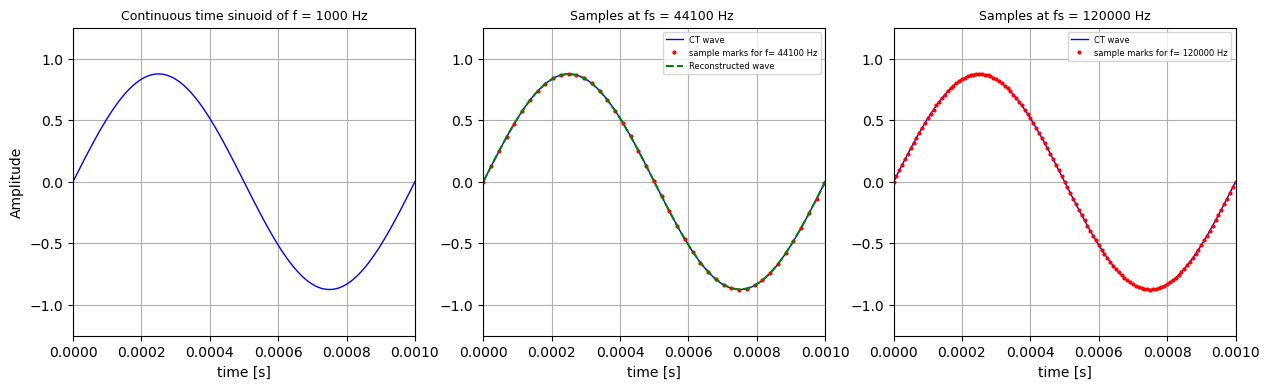

In [24]:
fig = plt.figure(figsize = (15,4))

plt.subplot(1,3,1)
plt.plot(t_ct, x_ct, color='blue', linewidth=1)
plt.xlim([0,duration/n_periods])
plt.ylim([-1.25, 1.25])
plt.xlabel('time [s]', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.title('Continuous time sinuoid of f = %d Hz' %(f_ct), fontsize = 9)
plt.grid()

#Sampled with fs_1 = 100
plt.subplot(1,3,2)
plt.plot(t_ct, x_ct, color='b', linewidth=1, label='CT wave')
plt.plot(t_smp1, x_smp1,'o',color='red',markersize=2, label= 'sample marks for f= %d Hz' %(fs_1))
plt.plot(t_smp1, x_smp1,'--',color='green',markersize=2, label= 'Reconstructed wave')
plt.title('Samples at fs = %d Hz ' %(fs_1), fontsize = 9)
plt.xlim([0, duration/n_periods])
plt.grid()
plt.ylim([-1.25, 1.25])
plt.xlabel('time [s]', fontsize=10)
plt.legend(prop={'size': 6})

#Sampled with fs2 = fs_ct
plt.subplot(1,3,3)
plt.plot(t_ct, x_ct, color='b', linewidth=1, label='CT wave')
plt.plot(t_smp2, x_smp2,'ro',markersize=2, label= 'sample marks for f= %d Hz' %(fs_2))
plt.title('Samples at fs = %d Hz' %(fs_2), fontsize = 9)
plt.xlim([0,duration/n_periods])
plt.grid()
plt.legend(prop={'size': 6})
plt.ylim([-1.25, 1.25])
plt.xlabel('time [s]', fontsize=10)

plt.show()


#### FFT analysis: CT signal

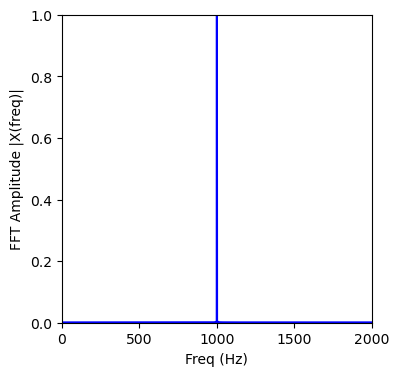

In [25]:
from scipy.signal import find_peaks

#Fourier transform of simple sine wave
X_ct = np.fft.fft(x_ct)
X_ct/= np.abs(X_ct).max() #normalize

#Frequency vector
N = len(X_ct)
n = np.arange(N)
T = N/fs_ct
freq = n/T

freq = np.fft.fftfreq(len(x_ct), 1/fs_ct)

plt.figure(figsize = (4, 4))
#plt.stem(freq, np.abs(X_ct), 'b' ,markerfmt=" ", basefmt="-b")
plt.plot(freq, np.abs(X_ct), 'b')

plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0,2000)
plt.ylim(0,1)
plt.show()



### 1.2 QUANTIZATION of CT signal

Simulation of a mid-tread quantizer of N=3 quantization bits

In [26]:
fs_ct = 120000;
Ts_ct = 1/fs_ct;

#Quantization period for plotting (?)
T=1/f_ct;       #period of CT wave
period=np.round((1/f_ct)*fs_ct).astype(int) #???


In [27]:
#Quantization step size

#Range of the input signal
range_max=a_max  # Maximum input range
range_min=-a_max   # Minumum input range

N_Qbits = 3    # Number of quant. bits

#Size of the quantization step
delta =(range_max-range_min)/(2**(N_Qbits)-1)

#N_steps above the central one 
N_steps = int((a_max + 0.5*delta)/delta)

#Encode quantization
x_q = np.round(x_ct/delta)

#Decode
x_ct_rec = x_q*delta


# Quantization Error
quant_error_ct=x_ct_rec-x_ct

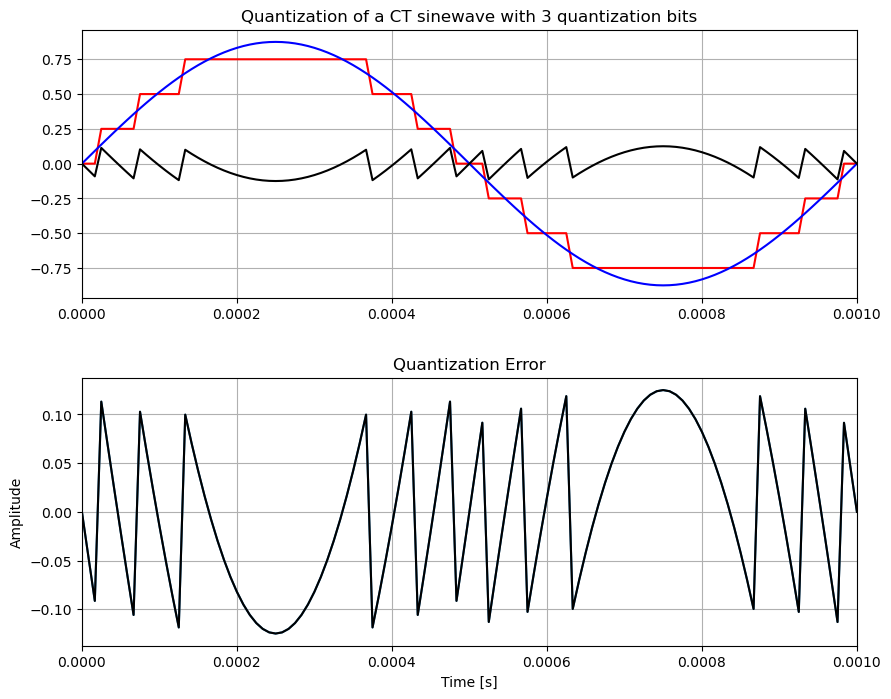

In [28]:
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(t_ct, x_ct_rec, 'r', label='Quantized wave')
plt.title('Quantization of a CT sinewave with %d quantization bits' %(N_Qbits), fontsize = 12)
plt.plot(t_ct, x_ct, 'b', label='Original wave')
plt.plot(t_ct, quant_error_ct, 'black', label='Quantization error')
plt.xlim([0, duration/n_periods])   
plt.grid() 

plt.subplot(2,1,2)
plt.plot(t_ct,quant_error_ct, label='Quantization Error (new t)')
plt.title('Quantization Error', fontsize=12)
plt.plot(t_ct, quant_error_ct, 'black', label='Quantization error (normal t))')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim([0,duration/n_periods])
plt.grid()

plt.subplots_adjust(hspace=0.3)
plt.show()

In [14]:
# Shape for plotting

#The numpy.delete() function returns a new array with the deletion
#of sub-arrays along with the mentioned axis.

t_quant=np.delete(np.repeat(t_ct[:period+1],2),-1)
x_q_rec_plot=np.delete(np.repeat(x_q_rec[:period+1],2),0)

# Quantization Error
quant_error_tread=x_q_rec-x_ct


NameError: name 'x_q_rec' is not defined

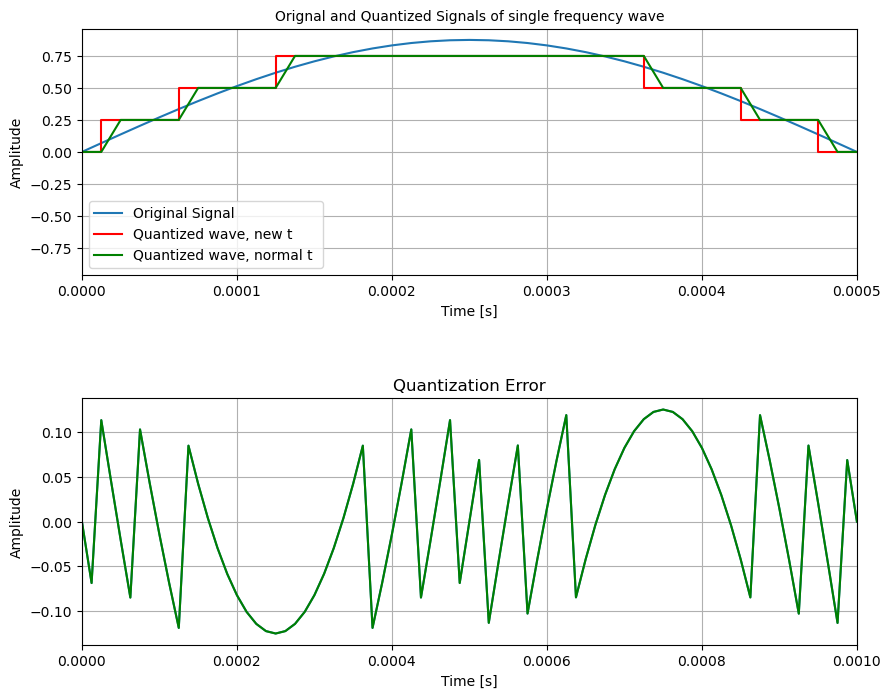

In [725]:
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(t_ct[:period+1],x_ct[:period+1], label='Original Signal')
plt.plot(t_quant,x_q_rec_plot, 'r', label='Quantized wave, new t')
plt.plot(t_ct, x_q_rec, 'g', label='Quantized wave, normal t ')
#plt.plot(t_ct[:period+1],quant_error_tread[:period+1], label='Quantization Error')
plt.title('Orignal and Quantized Signals of single frequency wave', fontsize=10)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
#plt.yticks(np.arange(-1-delta, 1+delta, delta))
plt.xlim([0,duration/n_periods/2])
plt.legend()
plt.grid()
#plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(t_ct[:period+1],quant_error_tread[:period+1], label='Quantization Error (new t)')
plt.title('Quantization Error', fontsize=12)
plt.plot(t_ct, quant_error_tread, 'g', label='Quantization error (normal t))')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim([0,duration/n_periods])
plt.grid()
#plt.tight_layout()
plt.subplots_adjust(hspace=0.5)


# plotly_fig = tls.mpl_to_plotly(fig)
#plotly_fig.layout.update(showlegend=True)
#plotly.offline.iplot(plotly_fig)

#### FFT analysis : CT vs Quantized signal

In [29]:
from scipy.fftpack import fft 

#Fourier transform of sine wave
X_ct = np.fft.fft(x_ct)
X_ct/= np.abs(X_ct).max()

#Fourier transform of quantized sine wave
X_ct_rec = np.fft.fft(x_ct_rec)
X_ct_rec/= np.abs(X_ct_rec).max()

#Frequency vector original wave
N = len(X_ct)
n = np.arange(N)
T = N/fs_ct
freq = n/T

#Frequency vector quantized wave
N = len(X_ct_rec)
n = np.arange(N)
T = N/fs_ct
freq_q = n/T

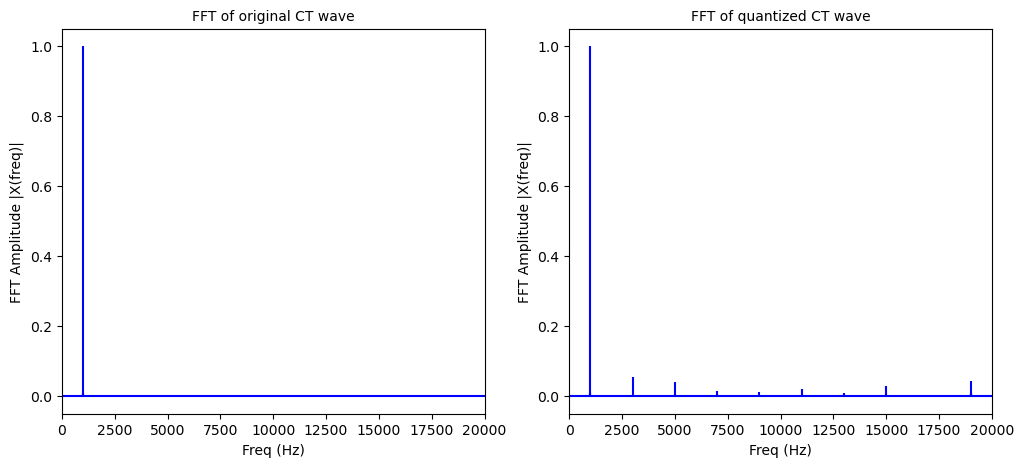

<Figure size 640x480 with 0 Axes>

In [30]:
plt.figure(figsize = (12, 5))

plt.subplot(1,2,1)
plt.stem(freq, np.abs(X_ct), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of original CT wave', fontsize=10)
plt.xlim(0,20000)

plt.subplot(1,2,2)
plt.stem(freq_q, np.abs(X_ct_rec), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of quantized CT wave', fontsize=10)
plt.xlim(0,20000)
plt.show()

plt.tight_layout()

C:\Users\Utente\AppData\Local\Temp\ipykernel_6968\3322059800.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq, 20*np.log10(np.abs(X_ct_rec)), 'b')


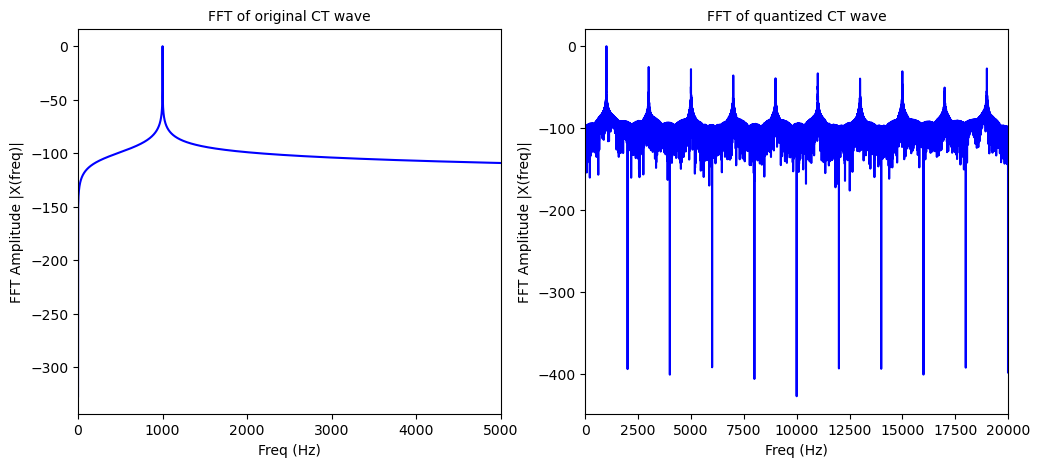

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize = (12, 5))

plt.subplot(1,2,1)
plt.plot(freq, 20*np.log10(np.abs(X_ct)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of original CT wave', fontsize=10)
plt.xlim(0,5000)

plt.subplot(1,2,2)
plt.plot(freq, 20*np.log10(np.abs(X_ct_rec)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of quantized CT wave', fontsize=10)
plt.xlim(0,20000)
plt.show()

plt.tight_layout()

### 1.3 QUANTIZATION + SAMPLING of signal 

In [32]:
T=1/f_ct; 
period_smp1=np.round((T)*fs_1).astype(int) 


#Range of the input signal
range_max=np.max(x_smp1)  # Maximum input range
range_min=np.min(x_smp1)  # Minumum input range
N_Qbits = 3    # Number of quant. bits

#Size of the quantization step
delta_smp1 =(range_max-range_min)/(2**(N_Qbits)-1)

#N_steps above the central one 
# N_steps = int((range_max + 0.5*delta_smp1)/delta_smp1)

#Encode quantization
x_qs1_ind = np.round(x_smp1/delta_smp1)
#Decode
x_s1_rec = x_qs1_ind*delta_smp1

# Quantization Error
quant_error_smp1 = x_s1_rec-x_smp1


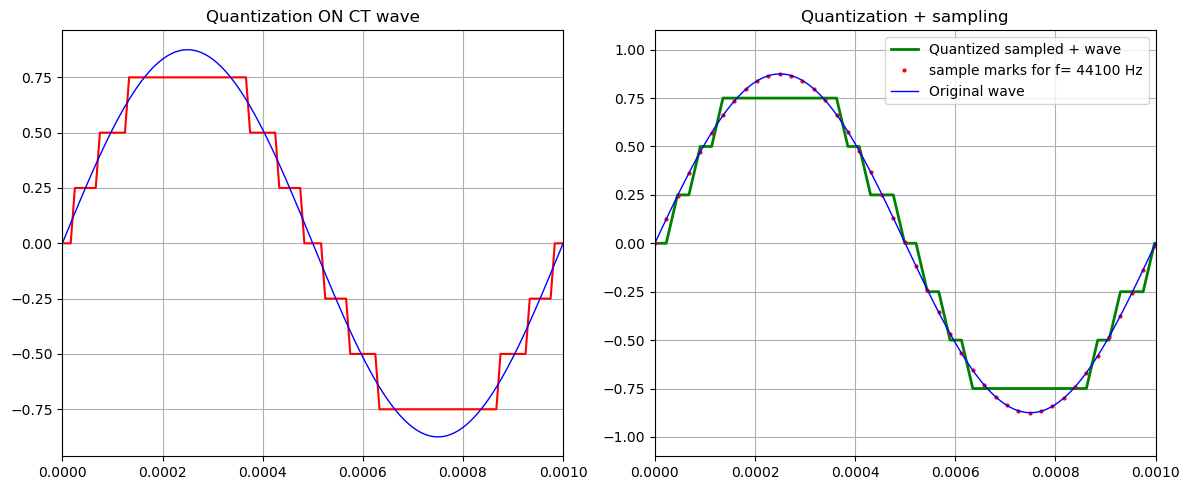

In [33]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(t_ct, x_ct_rec, 'r', label='Quantized wave')
plt.title('Quantization ON CT wave', fontsize = 12)
plt.plot(t_ct, x_ct, 'b', label='Original wave',  linewidth=1)
#plt.plot(t_ct, quant_error_ct, 'g', label='Quantization error')
plt.xlim([0, duration/n_periods])   
plt.grid() 

plt.subplot(1,2,2)
plt.plot(t_smp1, x_s1_rec, 'g', label='Quantized sampled + wave', linewidth=2)
plt.title('Quantization + sampling', fontsize = 12)
plt.plot(t_smp1, x_smp1,'o',color='red',markersize=2, label= 'sample marks for f= %d Hz' %(fs_1))
plt.plot(t_ct, x_ct, 'b', label='Original wave', linewidth=1)
#plt.plot(t_smp1, quant_error_smp1, 'g', label='Quantization error')
plt.xlim([0, duration/n_periods])
plt.grid()
plt.legend()

plt.tight_layout()

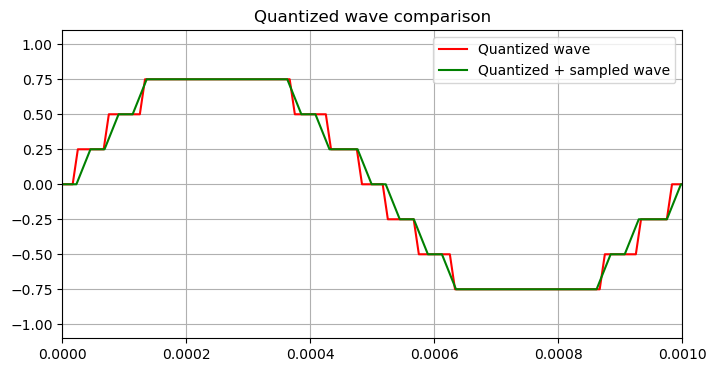

In [34]:
plt.figure(figsize=(8,4))

plt.plot(t_ct, x_ct_rec, 'r', label='Quantized wave')
plt.plot(t_smp1, x_s1_rec, 'g', label='Quantized + sampled wave')
plt.title("Quantized wave comparison", fontsize = 12)
plt.xlim([0, duration/n_periods])
plt.grid()
plt.legend()



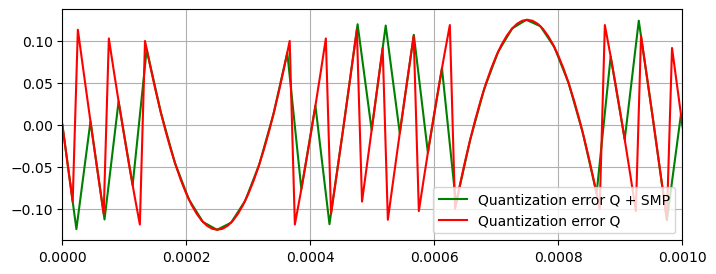

In [35]:
plt.figure(figsize=(8,3))

plt.plot(t_smp1, quant_error_smp1, 'g', label='Quantization error Q + SMP')
plt.plot(t_ct, quant_error_ct, 'r', label='Quantization error Q')
plt.xlim([0, duration/n_periods])
plt.grid()
plt.legend(loc='lower right')

#### FFT analysis: quantized + sampled signal

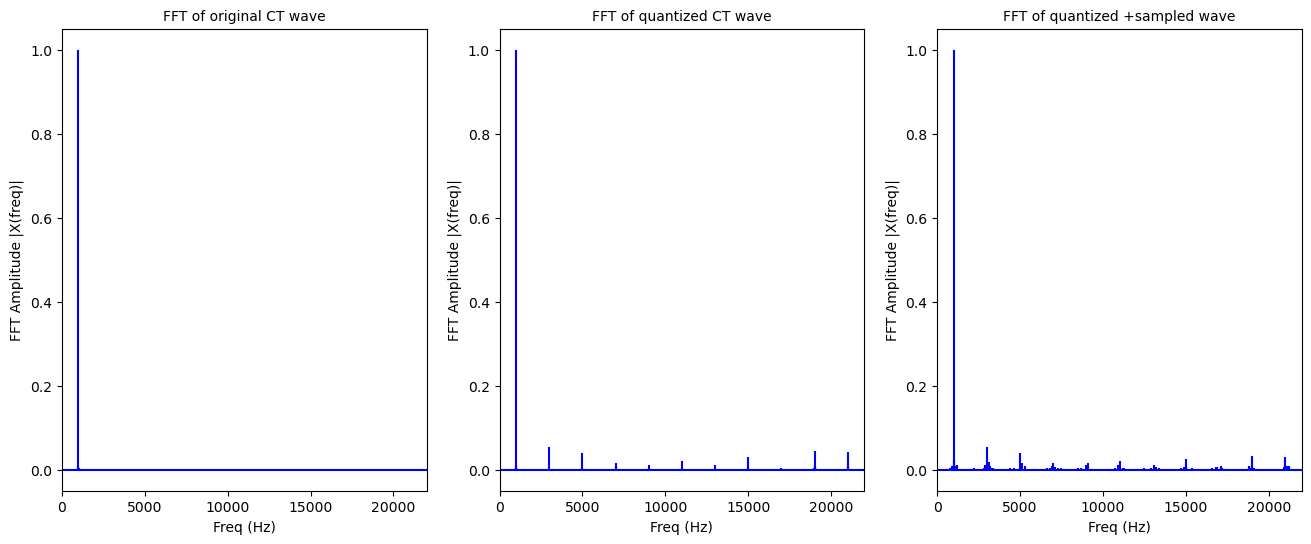

<Figure size 640x480 with 0 Axes>

In [36]:
#FFT QUANTIZED + SAMPLING 

X_s1_rec = np.fft.fft(x_s1_rec)
X_s1_rec/= np.abs(X_s1_rec).max()

#Frequency vector sampled + quantized wave
N = len(X_s1_rec)
n = np.arange(N)
T = N/fs_1
freq_qs1 = n/T

plt.figure(figsize = (16, 6))

plt.subplot(1,3,1)
plt.stem(freq, np.abs(X_ct), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of original CT wave', fontsize=10)
plt.xlim(0,22000)

plt.subplot(1,3,2)
plt.stem(freq_q, np.abs(X_ct_rec), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of quantized CT wave', fontsize=10)
plt.xlim(0,22000)

plt.subplot(1,3,3)
plt.stem(freq_qs1, np.abs(X_s1_rec), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of quantized +sampled wave', fontsize=10)
plt.xlim(0,22000)
plt.show()

plt.tight_layout()

C:\Users\Utente\AppData\Local\Temp\ipykernel_6968\3254636402.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq_q, 20*np.log10(np.abs(X_ct_rec)), 'b')


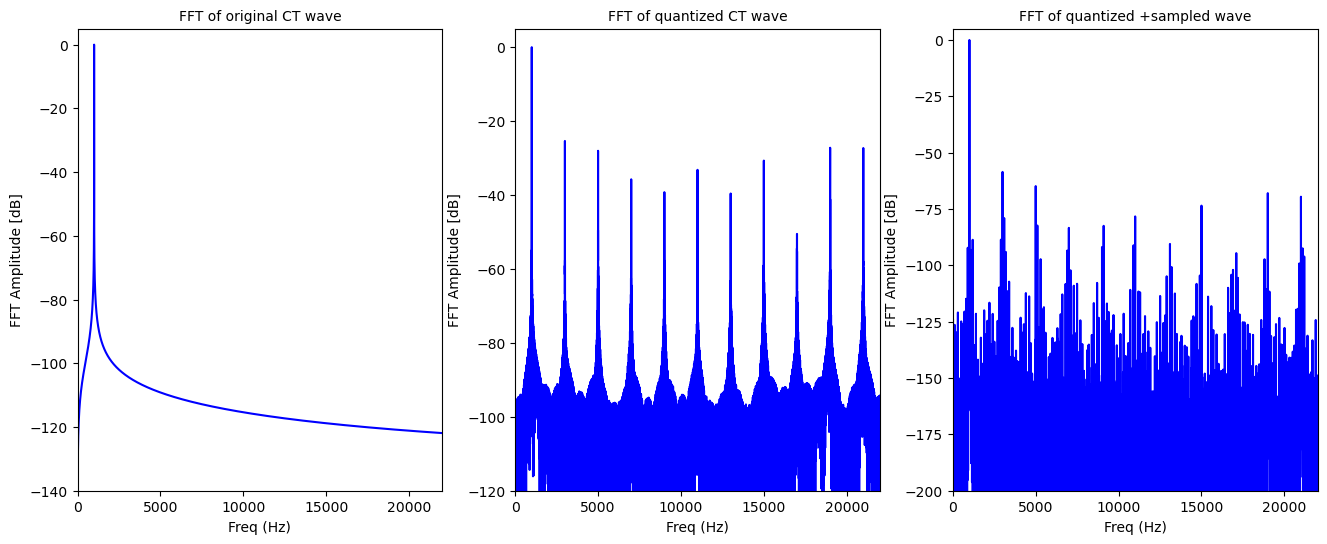

<Figure size 640x480 with 0 Axes>

In [37]:
plt.figure(figsize = (16, 6))

plt.subplot(1,3,1)
plt.plot(freq, 20*np.log10(np.abs(X_ct)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude [dB]')
plt.title('FFT of original CT wave', fontsize=10)
plt.ylim(-140,5)
plt.xlim(0,22000)

plt.subplot(1,3,2)
plt.plot(freq_q, 20*np.log10(np.abs(X_ct_rec)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude [dB]')
plt.title('FFT of quantized CT wave', fontsize=10)
plt.ylim(-120,5)
plt.xlim(0,22000)

plt.subplot(1,3,3)
plt.plot(freq_qs1, 20*np.log(np.abs(X_s1_rec)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude [dB]')
plt.title('FFT of quantized +sampled wave', fontsize=10)
plt.ylim(-200,5)
plt.xlim(0,22000)
plt.show()

plt.tight_layout()

### 1.4 Comparison with THEORETICAL QUANTIZATION

In [47]:
#Function for size of the delta step
def step_size(n):
    d = (2)/(2**(n))   # Assuming step normalized to 1 
    return d

#Function for maximum amplitude to allow simmetry 
def amp_f(n, d):
    amp = (2**(n-1) - 1)*d
    return amp 

#Number of quantization steps
def num_steps(n , amp, delta):
    
    a = 2**(n-1) -1 
    b = int((amp + 0.5*delta)/delta)
    N = np.minimum(a, b)

    return N

#Duty cycle of square wave
def duty(D, amp, n):
    d = np.zeros(n+1)
    for i in range(1,n+1):
        d[i] = 1/2 - (1/np.pi)*np.arcsin((2*i-1)*D/(2*amp))
    return d 

#Thresholds for quantization
def threshold(n, D):
    x = np.zeros(n+1)
    for i in range(1,n+1):
        x[i] = D*((2*i-1)/2)
    return x

In [48]:
f_th = 1000;
f_smp = f_th*100;

fs_th = fs_ct; # --> Try same sampling frequency as the original signal
print("Sampling frequency is: ", fs_th, "Hz, same as the original signal")
n_periods_th=1000;
dur_th=n_periods*1/f_th;
T_th=1/f_th;
#T_smp_th = 1/fs_th;

T_smp_th = 1/f_smp;

t_th= np.linspace(0,dur_th, int(np.ceil(dur_th/T_smp_th))) 
sin_wave_th = np.sin(2*np.pi*f_th*t_th)

print("Duration of the signal is: ", dur_th, "s")
print("The period of the signal is: ", T_th, "s")
print("Length of the time vector is: ", len(t_th), "samples")

idx_of_period_th = 120; 


sin_wave_1 = sinewave(1,dur_th,f_th,fs_th)

Sampling frequency is:  120000 Hz, same as the original signal
Duration of the signal is:  1.0 s
The period of the signal is:  0.001 s
Length of the time vector is:  100000 samples


In [49]:
N_qbits = 3;

delta = step_size(N_qbits);
A = amp_f(N_qbits, delta);
N_steps = num_steps(N_qbits, A, delta);

print("The max amplitude of the signal is: ", A)
print("The size of the step is: ", delta)
print("The number of steps is: ", N_steps)

The max amplitude of the signal is:  0.75
The size of the step is:  0.25
The number of steps is:  3


In [51]:
dc = duty(delta, A, N_steps)[1:]
print("Lenght of duty cicles: {}".format(dc))

x_thresh = threshold(N_steps, delta)[1:]
print("Height of thresholds: {}".format(x_thresh))

Lenght of duty cicles: [0.44669962 0.33333333 0.1864295 ]
Height of thresholds: [0.125 0.375 0.625]


In [52]:
# TEST
index = np.zeros((2*n_periods, len(x_thresh)))
index = [[],[],[]]

for i in range(1, len(sin_wave_th[0:120])):
    smp_mean = np.abs((sin_wave_th[i-1] + sin_wave_th[i+1])/2)

    #print("Previous sample {} - Current Sample: {} - Next sample: {}".format(sin_wave[i-1], sin_wave[i], sin_wave[i+1]))
    #print("Sample mean {}: {}".format(i, smp_mean))


    if (smp_mean > x_thresh[0]-0.03 and  smp_mean < x_thresh[0]+0.03):
        index[0].append(i)
        
    if (smp_mean > x_thresh[1]-0.02 and  smp_mean < x_thresh[1]+0.02):
        index[1].append(i)

    if (smp_mean > x_thresh[2]-0.02 and  smp_mean < x_thresh[2]+0.02):
        index[2].append(i)
 
print("Index of samples of first periods: {}".format(index))

Index of samples of first periods: [[2, 48, 52, 98, 102], [6, 44, 56, 94, 106], [11, 39, 61, 89, 111]]


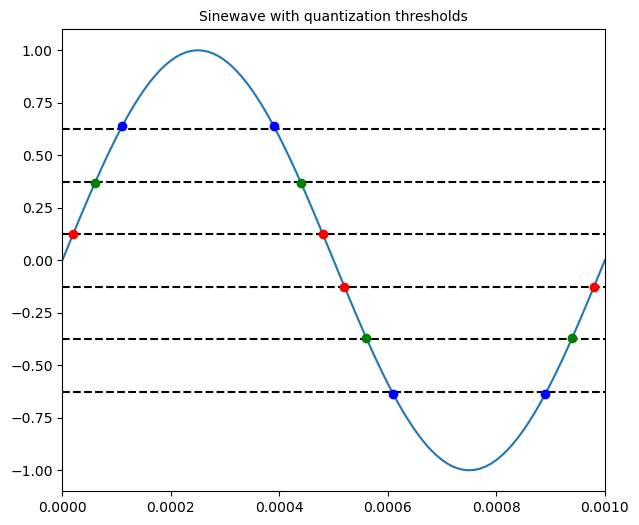

In [54]:
plt.figure(figsize=(7,6))

plt.plot(t_th,sin_wave_th)     
plt.xlim(0,T_th)
plt.hlines(x_thresh, 0, 0.001, colors='black', linestyles='dashed')
plt.hlines(-x_thresh, 0, 0.001, colors='black', linestyles='dashed')
plt.title('Sinewave with quantization thresholds', fontsize=10)

plt.plot(t_th[index[0]], sin_wave_th[index[0]], 'ro')
plt.plot(t_th[index[1]], sin_wave_th[index[1]], 'go')
plt.plot(t_th[index[2]], sin_wave_th[index[2]], 'bo')


Length of the square wave: 100000


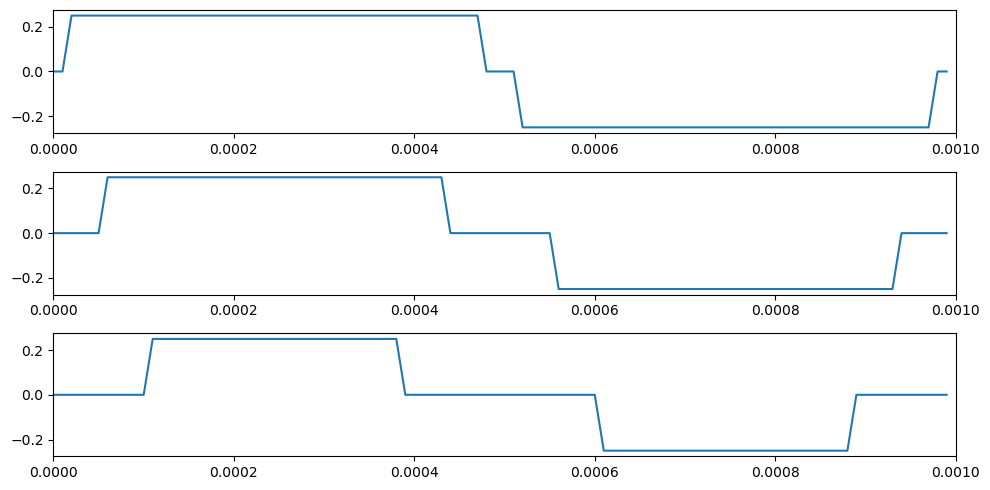

In [55]:
# Construction of square waves from the time indices and duty cyles obtained with formulas in the article
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
sq0 = np.zeros(len(t_th[0:100]))
sq0[index[0][0]:index[0][1]] = delta
sq0[index[0][0]+50:index[0][1]+50] = -delta
plt.xlim(0,T_th)
plt.plot(t_th[0:100],sq0)

plt.subplot(3,1,2)
sq1 = np.zeros(len(t_th[0:100]))
sq1[index[1][0]:index[1][1]] = delta
sq1[index[1][0]+50:index[1][1]+50] = -delta
plt.xlim(0,T_th)
plt.plot(t_th[0:100],sq1)

plt.subplot(3,1,3)
sq2 = np.zeros(len(t_th[0:100]))
sq2[index[2][0]:index[2][1]] = delta
sq2[index[2][0]+50:index[2][1]+50] = - delta
plt.xlim(0,T_th)
plt.plot(t_th[0:100],sq2)

plt.tight_layout()


sq_tot = sq0 + sq1 + sq2
sq_tot= np.tile(sq_tot, n_periods)

print("Length of the square wave: {}".format(len(sq_tot)))

In [57]:
# Functions for Fourier series for square wave 

k = 100

def c_n(D, nsteps, dc, n_idx):
    cn = 0

    for i in range(1,nsteps+1):
        tmp = (4*D)/(np.pi*n_idx)*np.sin(np.pi*n_idx/2)*np.sin(np.pi*n_idx*dc[i-1])
        cn = cn + tmp 
        #print("Nsteps: {} - tmp: {} - Cn: {}".format(i, tmp, cn))

    return cn


def q_out (D, nsteps, dc, T, t, k):
    q_out = np.zeros(len(t))
 
    for i in range(1, k):
        tmp = c_n(D, nsteps, dc, i)*np.sin(2*np.pi*i/T*t)
        q_out = q_out + tmp

    return q_out

(0.0, 0.001)

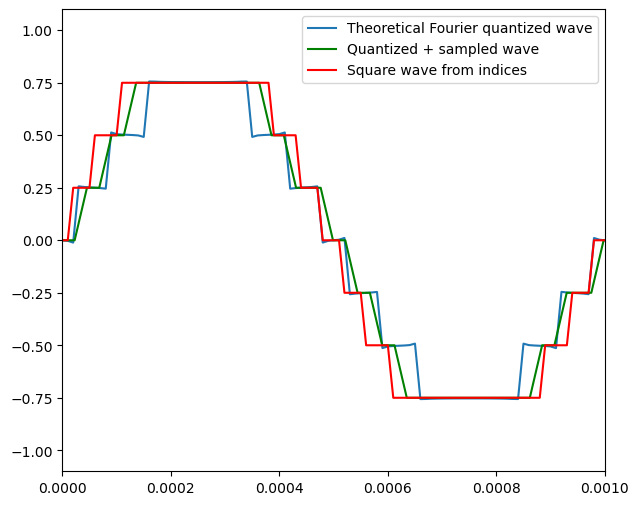

In [60]:
# Theoretical Fouries series

c_n(delta, N_steps, dc, 1)
                      
q_th = q_out(delta, N_steps, dc, T_th, t_th, k)

plt.figure(figsize=(7,6))
plt.plot(t_th, q_th, label = 'Theoretical Fourier quantized wave')
plt.plot(t_smp1, x_s1_rec, 'g', label='Quantized + sampled wave')
plt.plot(t_th, sq_tot, 'r', label='Square wave from indices')
plt.legend()
plt.xlim(0,T_th)

FFT analysis: square waves

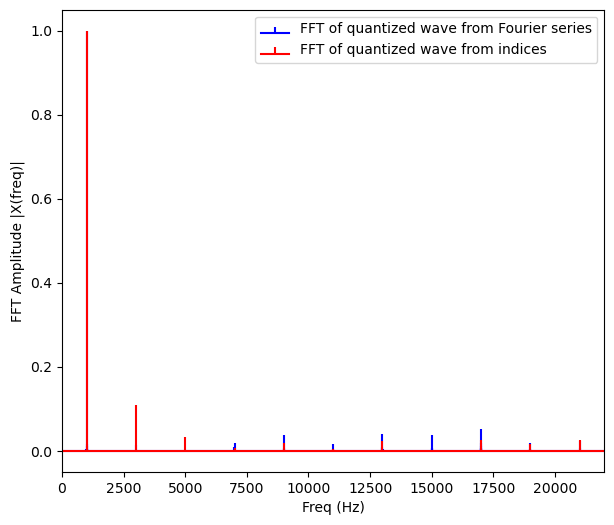

C:\Users\Utente\AppData\Local\Temp\ipykernel_6968\1717031363.py:25: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq, 20*np.log10(np.abs(X_sq_tot)), 'r')


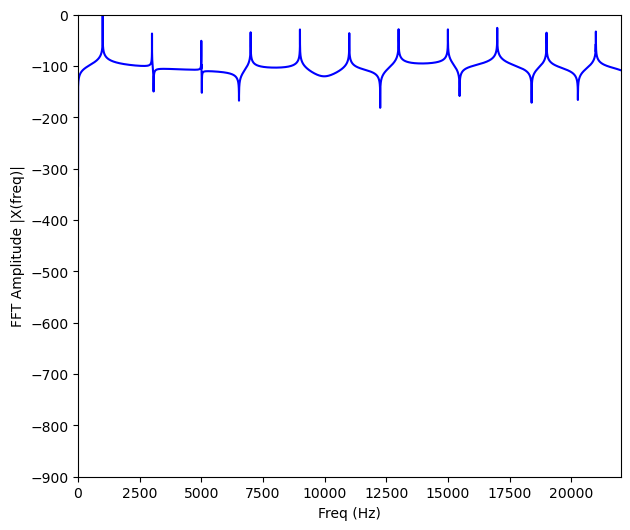

In [64]:
X_sq_th = np.fft.fft(q_th)
X_sq_th/= np.abs(X_sq_th).max()


X_sq_tot = np.fft.fft(sq_tot)
X_sq_tot/= np.abs(X_sq_tot).max()

#Frequency vector sampled + quantized wave
N = len(X_sq_th)
n = np.arange(N)
T = N/f_smp
freq = n/T

plt.figure(figsize=(7,6))
plt.stem(freq, np.abs(X_sq_th), 'b', markerfmt=" ", basefmt="-b", label='FFT of quantized wave from Fourier series')
plt.stem(freq, np.abs(X_sq_tot), 'r', markerfmt=" ", basefmt="-r", label='FFT of quantized wave from indices')
plt.xlabel('Freq (Hz)')
plt.legend()
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0,22000)
plt.show()

plt.figure(figsize=(7,6))
plt.plot(freq, 20*np.log10(np.abs(X_sq_th)), 'b')
plt.plot(freq, 20*np.log10(np.abs(X_sq_tot)), 'r')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.ylim(-900,0)
plt.xlim(0,22000)
plt.show()



C:\Users\Utente\AppData\Local\Temp\ipykernel_6968\3502907222.py:15: RuntimeWarning: divide by zero encountered in log
  plt.plot(freq_th, 20*np.log(np.abs(X_sq_tot)), 'r')


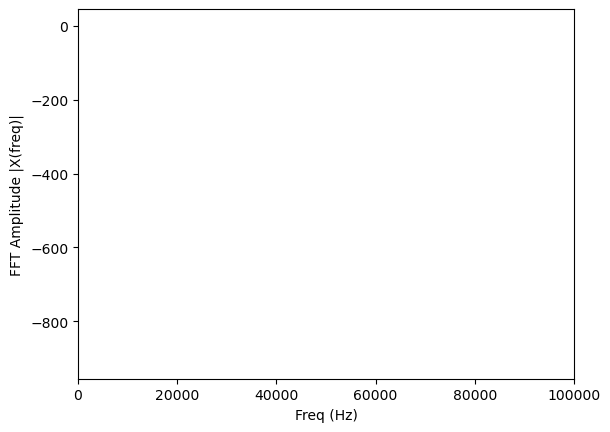

In [67]:
X_th = np.fft.fft(q_th)
X_th/= np.abs(X_th).max()

X_sq_tot = np.fft.fft(sq_tot)
X_sq_tot/= np.abs(X_sq_tot).max()

#Frequency vector sampled + quantized wave
N_th = len(X_th)
n_th= np.arange(N_th)
T_f_th = N/fs_th
freq_th= n_th/T_f_th

#plt.stem(freq_th, 20*np.log(np.abs(X_th)), 'b', markerfmt=" ", basefmt="-b")
#plt.plot(freq_th, 20*np.log(np.abs(X_th)), 'b')
plt.plot(freq_th, 20*np.log(np.abs(X_sq_tot)), 'r')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0,20000)
#plt.ylim(-120,0)
plt.show()

##  2. Compound sinusoid

In [71]:
#Composed sinusoid 
f1 = 200;
f2 = 400;
f3 = 1800;

fs_ct_comp=72000*5;

fs_smp_comp = 4330; # sampling frequency from article 

t_comp1, x_comp1 = sinewave(a_max, duration,f1,fs_ct) 
t_comp2, x_comp2 = sinewave(a_max, duration,f2,fs_ct) 
t_comp3, x_comp3 = sinewave(a_max, duration,f3,fs_ct)

print("Length of time vector of each compound : ", len(t_comp1),len(t_comp2),len(t_comp3))

x_comp = x_comp1 + x_comp2 + x_comp3
t_comp = t_comp1;

#Composed sampled time wave at fs = 4330 Hz
t_c_smp = smp_time(fs_smp_comp, duration)

t_c_smp1, x_c_smp1 = sinewave(a_max, duration,f1,fs_smp_comp) 
t_c_smp2, x_c_smp2 = sinewave(a_max, duration,f2,fs_smp_comp) 
t_c_smp3, x_c_smp3 = sinewave(a_max, duration,f3,fs_smp_comp)

x_c_smp = x_c_smp1 + x_c_smp2 + x_c_smp3;
t_c_smp = t_c_smp1;

#------------------------------------------------------------
print("Length of CT t_comp, x_comp: ",len(t_comp), len(x_comp))
print("Length of sampled t_c_smp, x_c_smp: ",len(t_c_smp), len(x_c_smp))


Length of time vector of each compound :  120000 120000 120000
Length of CT t_comp, x_comp:  120000 120000
Length of sampled t_c_smp, x_c_smp:  4330 4330


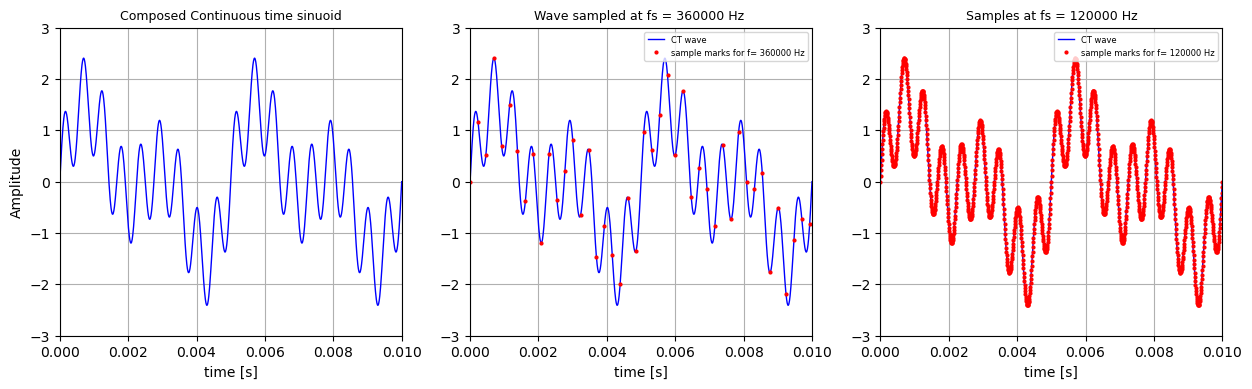

In [73]:
fig = plt.figure(figsize = (15,4))

plt.subplot(1,3,1)
plt.plot(t_comp, x_comp, color='b', linewidth=1)
plt.xlim([0,0.01])
plt.ylim([-3, 3])
plt.xlabel('time [s]', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.title('Composed Continuous time sinuoid', fontsize = 9)
plt.grid()

plt.subplot(1,3,2)
plt.plot(t_comp, x_comp, color='b', linewidth=1, label='CT wave')
plt.plot(t_c_smp, x_c_smp,'ro',markersize=2, label= 'sample marks for f= %d Hz' %(fs_ct_comp))
plt.title('Wave sampled at fs = %d Hz ' %(fs_ct_comp), fontsize = 9)
plt.xlim([0,0.01])
plt.ylim([-3, 3])
plt.xlabel('time [s]', fontsize=10)
plt.legend(prop={'size': 6})
plt.grid()
#plt.ylabel('Amplitude', fontsize=10)

plt.subplot(1,3,3)
plt.plot(t_comp, x_comp, color='b', linewidth=1, label='CT wave')
plt.plot(t_comp, x_comp,'ro',markersize=2, label= 'sample marks for f= %d Hz' %(fs_2))
plt.title('Samples at fs = %d Hz' %(fs_2), fontsize = 9)
plt.xlim([0,duration/n_periods])
plt.grid()
plt.legend(prop={'size': 6})
plt.ylim([-3,3])
plt.xlim([0,0.01])
plt.xlabel('time [s]', fontsize=10)

plt.show()

#### FFT analysis: compound signal

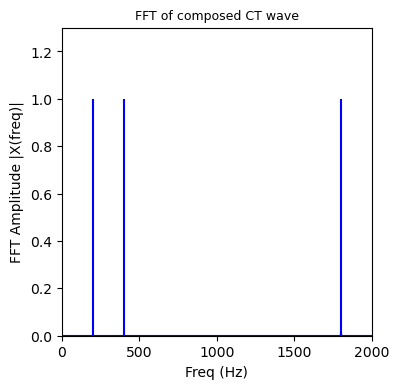

In [74]:
#Fourier transform of composed wave

#Fourier transform of simple sine wave
X_comp = np.fft.fft(x_comp)
X_comp/= np.abs(X_comp).max()
freq_comp = np.fft.fftfreq(len(x_comp), 1/fs_ct)

peaks, _= find_peaks(freq_comp, height=0.1)


#.plot(freq_c[NFFT//2:NFFT-1], np.abs(X_c)[NFFT//2:NFFT-1], color='b', linewidth=1)
#plt.plot(freq_c[peaks], np.abs(X_c)[peaks], 'rx', markersize=4)
#plt.title('Frequency spectrum of composed CT wave', fontsize = 9)
#plt.xlabel('Frequency [Hz]', fontsize=9)
#plt.ylabel('Magnitude', fontsize=9)
#plt.xlim([0,NFFT])


plt.figure(figsize = (4, 4))
plt.stem(freq_comp, np.abs(X_comp), 'b' ,markerfmt=" ", basefmt="-b")
plt.plot(freq_comp[peaks], np.abs(X_comp)[peaks], 'rx', markersize=4)
plt.title('FFT of composed CT wave', fontsize = 9)
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0,2000)
plt.ylim(0,1.3)
plt.show()

#### Quantization of compound CT sinusoid

In [75]:
#Range of the input signal
range_max=np.max(x_comp)  # Maximum input range
range_min=np.min(x_comp)  # Minumum input range
N_Qbits = 3   # Number of quant. bits

#Size of the quantization step
delta_comp =(range_max-range_min)/(2**(N_Qbits)-1)

#N_steps above the central one 
N_steps = int((range_max + 0.5*delta_comp)/delta_comp)

#Encode quantization
x_comp_ind = np.round(x_comp/delta_comp)

#Decode
x_comp_rec = x_comp_ind*delta_comp

# Quantization Error
quant_error_comp= x_comp_rec-x_comp

figure  = plt.figure(figsize = (15,8))


<Figure size 1500x800 with 0 Axes>

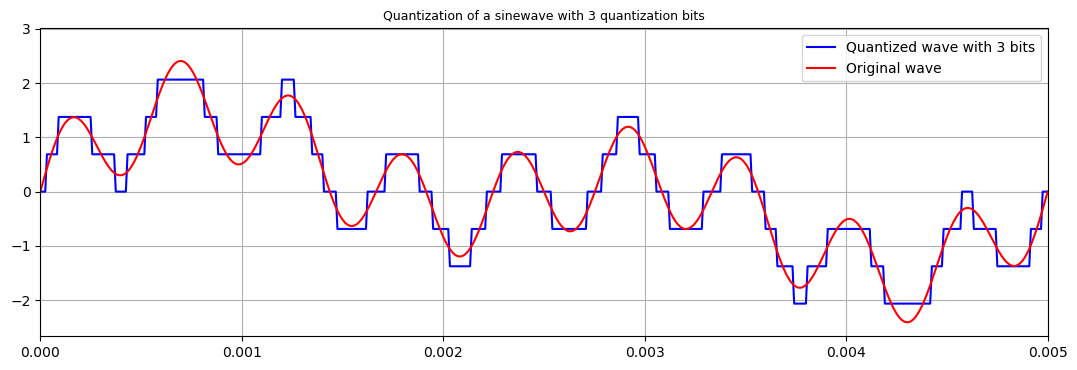

In [76]:
fig = plt.figure(figsize = (13,4))
plt.plot(t_comp, x_comp_rec, 'b', label='Quantized wave with 3 bits')
plt.plot(t_comp, x_comp, 'r', label='Original wave')
#plt.plot(t_comp, quant_error_comp, 'g', label='Quantization error')
plt.title('Quantization of a sinewave with %d quantization bits' %(N_Qbits), fontsize = 9)
plt.xlim([0, 0.005]) 
plt.legend()  
plt.grid()


#### Fourier analysis of the quantized compound signal

In [77]:
from scipy.fftpack import fft 

#Fourier transform of simple sine wave
X_comp = np.fft.fft(x_comp)
X_comp/= np.abs(X_comp).max()

#Fourier transform of quantized simple sine wave
X_comp_rec = np.fft.fft(x_comp_rec)
X_comp_rec/= np.abs(X_comp_rec).max()

#Frequency vector original wave
N = len(X_comp)
n = np.arange(N)
T = N/fs_ct
freq_comp = n/T

#Frequency vector quantized wave
N = len(X_comp_rec)
n = np.arange(N)
T = N/fs_ct
freq_q = n/T


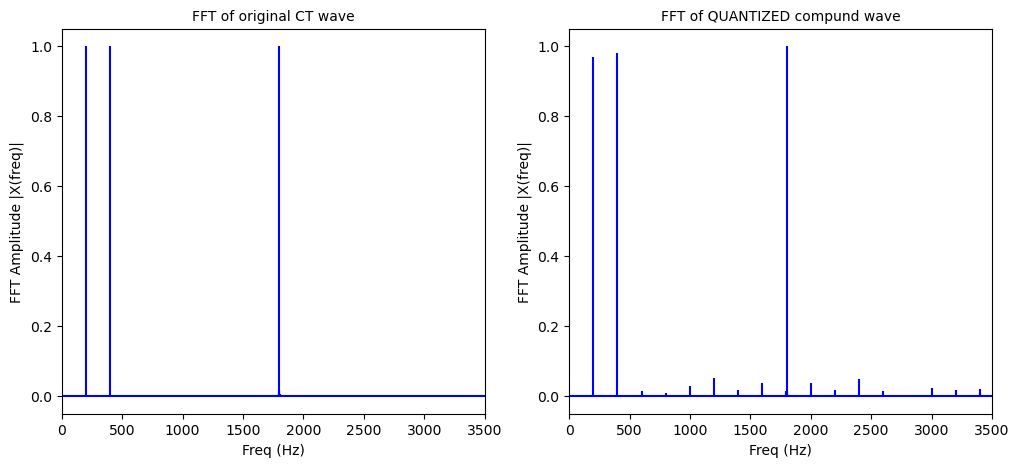

<Figure size 640x480 with 0 Axes>

In [78]:
plt.figure(figsize = (12, 5))

plt.subplot(1,2,1)
plt.stem(freq_comp, np.abs(X_comp), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of original CT wave', fontsize=10)
plt.xlim(0,3500)

plt.subplot(1,2,2)
plt.stem(freq_q, np.abs(X_comp_rec), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of QUANTIZED compund wave', fontsize=10)
plt.xlim(0,3500)
plt.show()

plt.tight_layout()

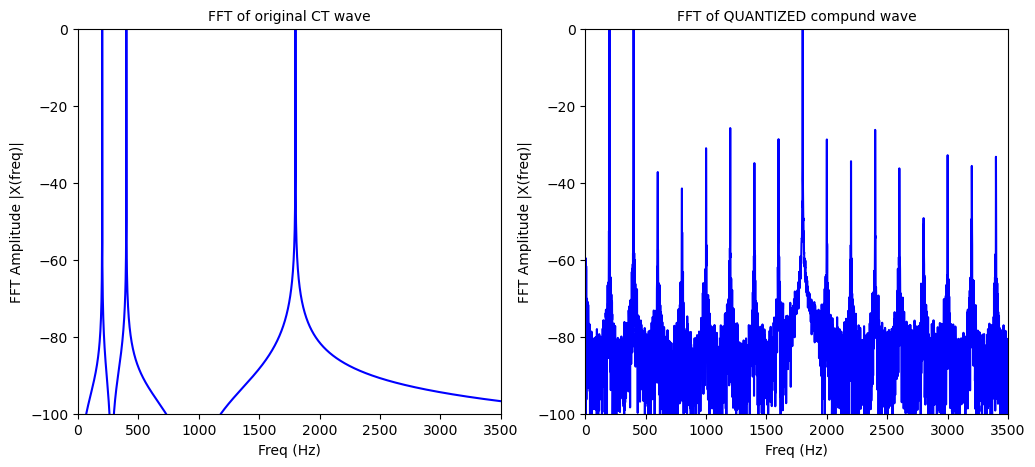

<Figure size 640x480 with 0 Axes>

In [81]:
plt.figure(figsize = (12, 5))

plt.subplot(1,2,1)
plt.plot(freq_comp, 20*np.log10(np.abs(X_comp)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of original CT wave', fontsize=10)
plt.ylim(-100,0)
plt.xlim(0,3500)

plt.subplot(1,2,2)
plt.plot(freq_q, 20*np.log10(np.abs(X_comp_rec)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of QUANTIZED compund wave', fontsize=10)
plt.xlim(0,3500)
plt.ylim(-100,0)
plt.show()

plt.tight_layout()

#### Quantization + sampling of compound sinusoid

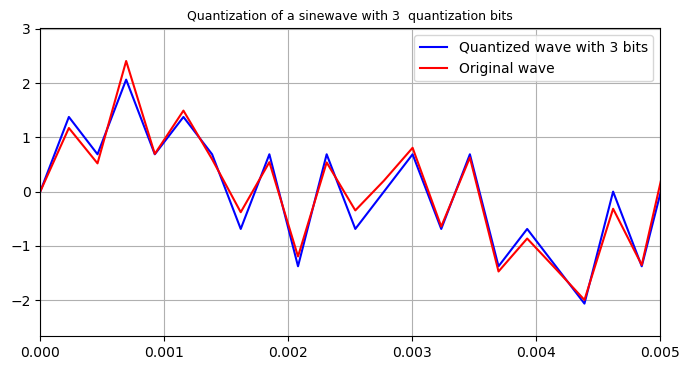

In [82]:
#Range of the input signal
range_max=np.max(x_c_smp)  # Maximum input range
range_min=np.min(x_c_smp)  # Minumum input range
N_Qbits = 3   # Number of quant. bits

#Size of the quantization step
delta_c_smp =(range_max-range_min)/(2**(N_Qbits)-1)

#N_steps above the central one 
N_steps_s = int((range_max + 0.5*delta_c_smp)/delta_c_smp)

#Encode quantization
x_c_ind_smp= np.round(x_c_smp/delta_c_smp)

#Decode
x_c_smp_rec = x_c_ind_smp*delta_c_smp

# Quantization Error
quant_error_c_smp= x_c_smp_rec-x_c_smp

figure  = plt.figure(figsize = (8,4))

plt.plot(t_c_smp, x_c_smp_rec, 'b', label='Quantized wave with 3 bits')
plt.plot(t_c_smp, x_c_smp, 'r', label='Original wave')
#plt.plot(t_comp, quant_error_comp, 'g', label='Quantization error')
plt.title('Quantization of a sinewave with %d  quantization bits' %(N_Qbits), fontsize = 9)
plt.xlim([0, 0.005]) 
plt.legend()  
plt.grid()



#### Fourier analysis of the quantized + sampled compound signal

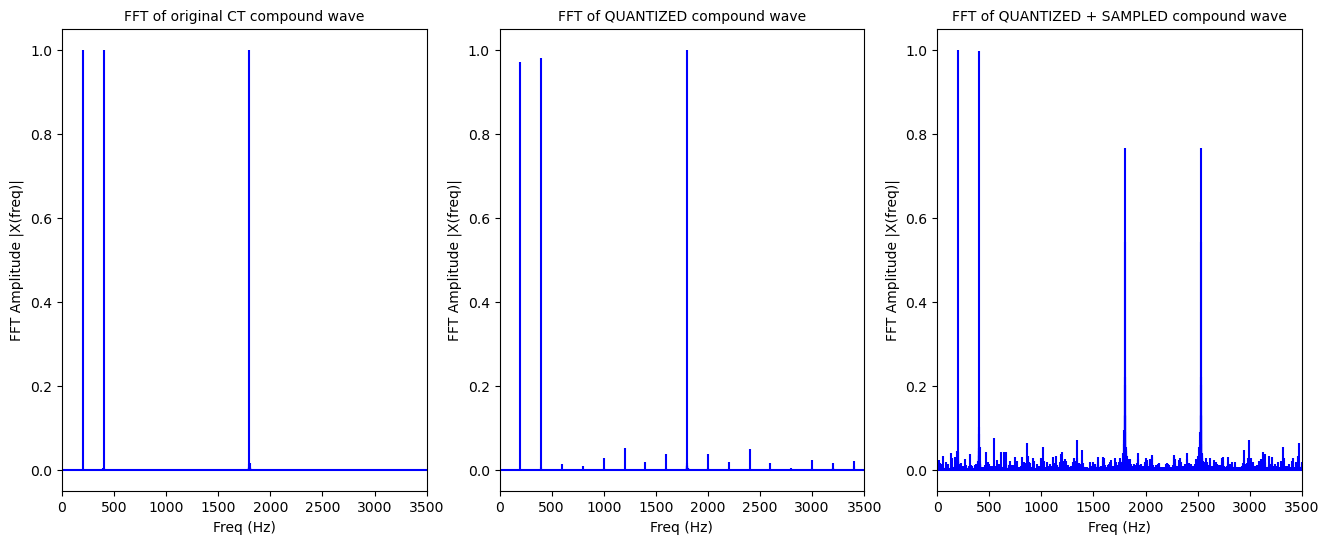

<Figure size 640x480 with 0 Axes>

In [85]:
#FFT QUANTIZED composed wave
X_c_smp_rec = np.fft.fft(x_c_smp_rec)
X_c_smp_rec/= np.abs(X_c_smp_rec).max()

#Frequency vector sampled + quantized wave
N = len(X_c_smp_rec)
n = np.arange(N)
T = N/fs_smp_comp
freq_c_smp = n/T

plt.figure(figsize = (16, 6))

plt.subplot(1,3,1)
plt.stem(freq_comp, np.abs(X_comp), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of original CT compound wave', fontsize=10)
plt.xlim(0,3500)

plt.subplot(1,3,2)
plt.stem(freq_q, np.abs(X_comp_rec), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of QUANTIZED compound wave', fontsize=10)
plt.xlim(0,3500)

plt.subplot(1,3,3)
plt.stem(freq_c_smp, np.abs(X_c_smp_rec), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of QUANTIZED + SAMPLED compound wave', fontsize=10)
plt.xlim(0,3500)
plt.show()

plt.tight_layout()

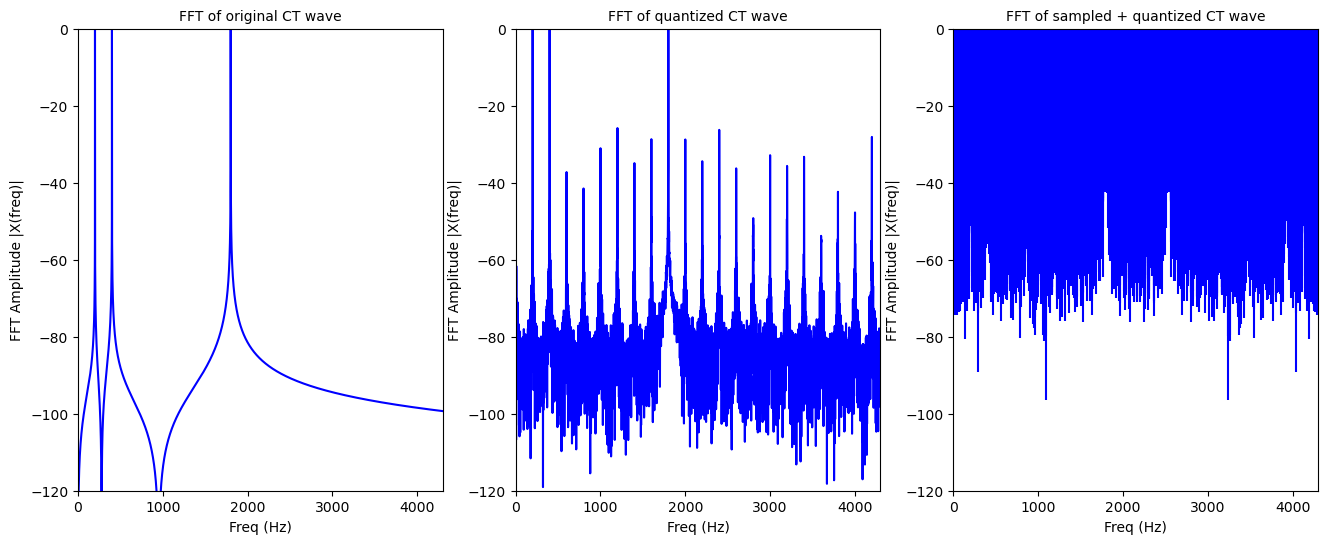

<Figure size 640x480 with 0 Axes>

In [89]:
plt.figure(figsize = (16, 6))

plt.subplot(1,3,1)
plt.plot(freq_comp, 20*np.log10(np.abs(X_comp)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of original CT wave', fontsize=10)
plt.ylim(-120,0)
plt.xlim(0,4300)

plt.subplot(1,3,2)
plt.plot(freq_q, 20*np.log10(np.abs(X_comp_rec)), 'b')
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of quantized CT wave', fontsize=10)
plt.ylim(-120,0)
plt.xlim(0,4300)

plt.subplot(1,3,3)
plt.stem(freq_c_smp, 20*np.log10(np.abs(X_c_smp_rec)), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('FFT of sampled + quantized CT wave', fontsize=10)
plt.xlim(0,4300)
plt.ylim(-120,0)
plt.show()

plt.tight_layout()